___2. ALTÉMA: TECHNOLÓGIA VS INDÍTÁS___

*0) Importok és beállítások*

In [9]:

from utils import (
    countries, non_english_countries, iso2_to_iso3,
    get_countries_df, add_iso3,
    fetch_gnews_for_countries,
    score_sentiment_vader, load_xlmr_model, predict_sentiment_batch_xlmr,
    make_country_aggregates, plot_four_maps_for_topic, top_examples_all
)

# VADER lexikon (EN-hez)
import nltk
nltk.download('vader_lexicon', quiet=True)

TOPIC_NAME = "tech_launch"   # vagy: moon_mars / politics_finance
USE_CACHE  = True                # ha van korábbi CSV, onnan olvas


*1) Keresőkifejezés (Technológia/Indítás altéma)*

In [10]:
TOPIC_NAME = "tech_launch"

base_terms = [
    '"space exploration"', '"space mission"', '"space flight"',
    'NASA','ESA','SpaceX','Blue Origin','ISRO','Roscosmos',
    'satellite','telescope','rocket','lunar','moon','mars','rover'
]
theme_terms = [
    'launch','rocket','booster','payload','Starship',
    'satellite','telescope','rover'
]
topic_base = " OR ".join(base_terms)
topic_theme = " OR ".join(theme_terms)
topic_query = f"({topic_base}) AND ({topic_theme})"

*2) Angol hírek lekérése + VADER + mentés*

In [11]:
import os, pandas as pd
en_raw  = f"data/raw/{TOPIC_NAME}_en_raw.csv"
en_proc = f"data/processed/{TOPIC_NAME}_en.csv"
os.makedirs("data/raw", exist_ok=True); os.makedirs("data/processed", exist_ok=True)

if USE_CACHE and os.path.exists(en_proc):
    news_en = pd.read_csv(en_proc)
else:
    news_en = fetch_gnews_for_countries(topic_query, countries, limit=120, source_lang="EN")
    news_en.to_csv(en_raw, index=False)  # nyers

    news_en["sentiment"] = news_en["title"].apply(score_sentiment_vader)
    news_en["sentiment_label"] = news_en["sentiment"].apply(
        lambda x: "positive" if x>=0.2 else ("negative" if x<=-0.2 else "neutral")
    )
    news_en = add_iso3(news_en, "iso2")
    news_en.to_csv(en_proc, index=False)  # feldolgozott

*3) Nem angol hírek + XLM-R + mentés*

In [12]:
non_raw  = f"data/raw/{TOPIC_NAME}_non_en_raw.csv"
non_proc = f"data/processed/{TOPIC_NAME}_non_en.csv"

if USE_CACHE and os.path.exists(non_proc):
    news_non = pd.read_csv(non_proc)
else:
    news_non = fetch_gnews_for_countries(topic_query, non_english_countries, limit=120, source_lang="NON_EN")
    news_non.to_csv(non_raw, index=False)

    tok, mdl, device = load_xlmr_model()
    news_non["sentiment_label"] = predict_sentiment_batch_xlmr(news_non["title"].tolist(), tok, mdl, device)
    news_non["sentiment"] = news_non["sentiment_label"].map({"negative":-1.0,"neutral":0.0,"positive":1.0})
    news_non = add_iso3(news_non, "iso2")
    news_non.to_csv(non_proc, index=False)

*4) Összefűzés + skálázás*

In [13]:
all_news = pd.concat([news_en, news_non], ignore_index=True)

# ha kombinált mediánt/átlagot szeretnénk -1/0/+1-en: EN átskálázása
def to_combo(row):
    if row["source_lang"] == "EN":
        x = row["sentiment"]
        return 1.0 if x>=0.2 else (-1.0 if x<=-0.2 else 0.0)
    return row["sentiment"]

all_news["sentiment"] = all_news.apply(to_combo, axis=1)

*5) Kibővített vizualizáció (4 térkép) + CSV-k*

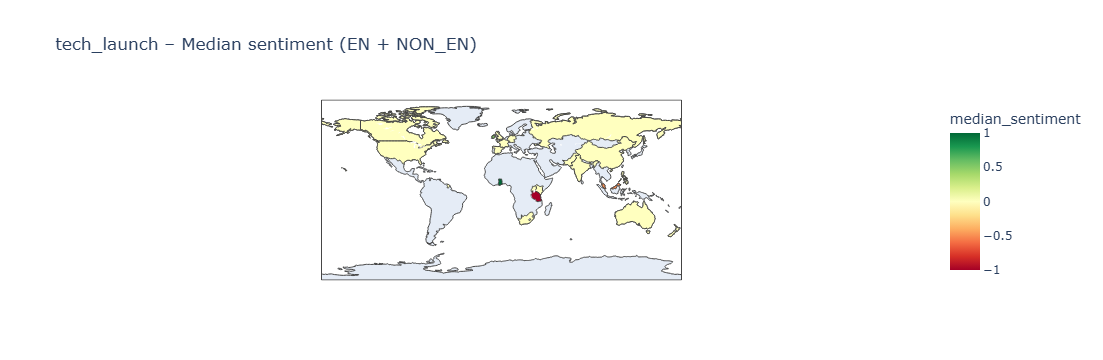

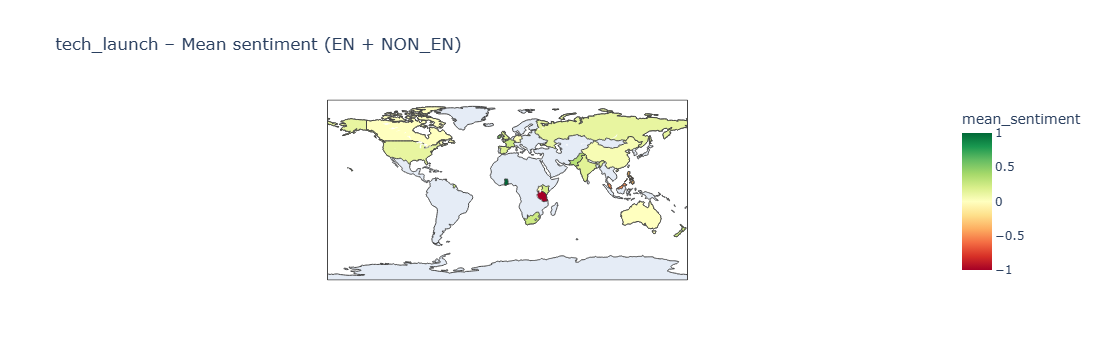

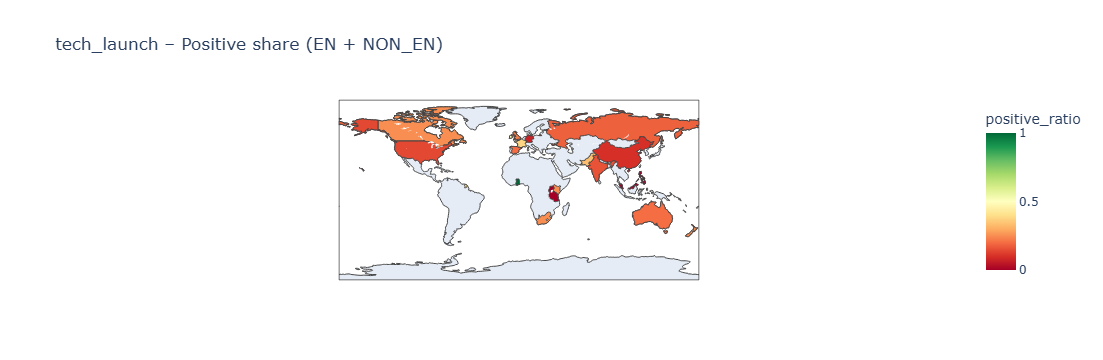

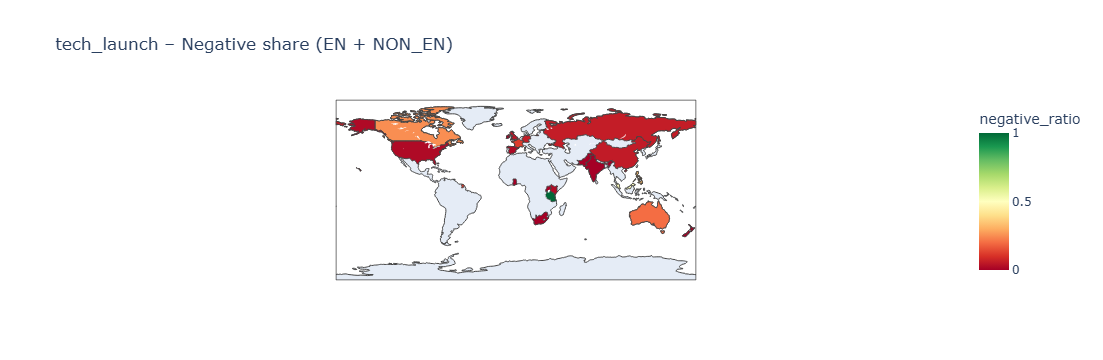

In [14]:
plot_four_maps_for_topic(all_news, topic_name=TOPIC_NAME, use_iso3=True)

*6) Példacímek (Hiszem, ha látom)*

In [15]:
top_pos = top_examples_all(all_news, "positive", 10, per_country=False)
top_neg = top_examples_all(all_news, "negative", 10, per_country=False)
display(top_pos); display(top_neg)

,country,source_lang,title,sentiment,sentiment_label,source,link
0,United States,EN,NASA Seeks Proposals for 2026 Human Exploratio...,1.0,positive,NASA (.gov),https://news.google.com/rss/articles/CBMiuAFBV...
1,United States,EN,NASA Seeks Student Teams For 2026 Human Explor...,1.0,positive,The BayNet,https://news.google.com/rss/articles/CBMilAFBV...
2,United States,EN,NASA seeks student entries for Human Explorati...,1.0,positive,upi.com,https://news.google.com/rss/articles/CBMikAFBV...
3,United States,EN,Uranus may have a 29th moon - Popular Science,1.0,positive,Popular Science,https://news.google.com/rss/articles/CBMiYkFVX...
4,United States,EN,What would Mars look like in daylight? 'Enhanc...,1.0,positive,USA Today,https://news.google.com/rss/articles/CBMiqwFBV...
5,United States,EN,NASA rover spots rock shaped like medieval hel...,1.0,positive,New York Post,https://news.google.com/rss/articles/CBMinAFBV...
6,United States,EN,An Area Known as ‘Falbreen’ on Mars Saw Some B...,1.0,positive,thisiscolossal.com,https://news.google.com/rss/articles/CBMibEFVX...
7,United States,EN,NASA’s Perseverance Rover Captures Mars Vista ...,1.0,positive,NASA Jet Propulsion Laboratory (JPL) (.gov),https://news.google.com/rss/articles/CBMilgFBV...
8,United States,EN,Exclusive | NASA + ISRO + One Vision: Project ...,1.0,positive,ETV Bharat,https://news.google.com/rss/articles/CBMi0wFBV...
9,United States,EN,Bright Moonlight Could Interfere with View of ...,1.0,positive,NASA (.gov),https://news.google.com/rss/articles/CBMitAFBV...


,country,source_lang,title,sentiment,sentiment_label,source,link
0,United States,EN,Hijacked Satellites And Orbiting Space Weapons...,-1.0,negative,ETV Bharat,https://news.google.com/rss/articles/CBMi5gFBV...
1,United States,EN,Critics shouldn’t block NASA’s nuclear path to...,-1.0,negative,The Hill,https://news.google.com/rss/articles/CBMihgFBV...
2,United Kingdom,EN,NASA bids goodbye to Mars and admits its bigge...,-1.0,negative,El Diario 24,https://news.google.com/rss/articles/CBMifEFVX...
3,Canada,EN,NASA faces cuts to rocket program and lunar sp...,-1.0,negative,CBC,https://news.google.com/rss/articles/CBMiakFVX...
4,Canada,EN,NASA Orbiter Spots Curiosity Rover Making Trac...,-1.0,negative,NASA Jet Propulsion Laboratory (JPL) (.gov),https://news.google.com/rss/articles/CBMiogFBV...
5,Australia,EN,Have we been wrong about why Mars is red? - Eu...,-1.0,negative,European Space Agency,https://news.google.com/rss/articles/CBMiqwFBV...
6,Australia,EN,NASA Unveils Possible Building Blocks of Life ...,-1.0,negative,SciTechDaily,https://news.google.com/rss/articles/CBMimAFBV...
7,Philippines,EN,A NASA rover finally found Mars’ missing carbo...,-1.0,negative,Science News,https://news.google.com/rss/articles/CBMiggFBV...
8,Kenya,EN,Europe’s Moon plans at risk as Trump team revi...,-1.0,negative,Financial Times,https://news.google.com/rss/articles/CBMicEFVX...
9,Hong Kong,EN,CANCELLED: Muncie Three Trails Music Series – ...,-1.0,negative,Ball State University,https://news.google.com/rss/articles/CBMinAFBV...
